In [1]:
import numpy as np
import pandas as pd
import numpy.random as rnd
import matplotlib.pyplot as plt 
#import brewer2mpl
import scipy.linalg as lin
#import ggplot 
import re
import seaborn as sns

In [2]:
df= pd.read_excel(r'C:\Users\z103684\Desktop\New_data.xlsx',sep=';')
#df1=df.replace(to_replace=',', value='.', regex=True)
#df2=df1.replace(to_replace='0.0000', value='0', regex=True)
df1=df.loc[:, (df != 0).any(axis=0)]
#print(df1)
#index = list(range(15671))
#df1["index"] = index
#print(df1.columns)
print(df1.shape)

(15671, 13)


In [3]:
X1 = df1.iloc[1:,[4]]
dataset = X1.astype('float32')
#print(dataset)
dataset['date'] = pd.date_range(start='1/1/2020', periods=len(dataset), freq='D')
dataset=dataset.set_index('date')


In [4]:
dataset.rename(columns={'timeslices[4].profilerDataProcess[51]_C0[us]':'close'},inplace=True)
#dataset['close']= round(dataset['close'])
dataset.head()


,close
date,
2020-01-01,66.720001
2020-01-02,66.720001
2020-01-03,66.720001
2020-01-04,66.720001
2020-01-05,66.720001


c:\app\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


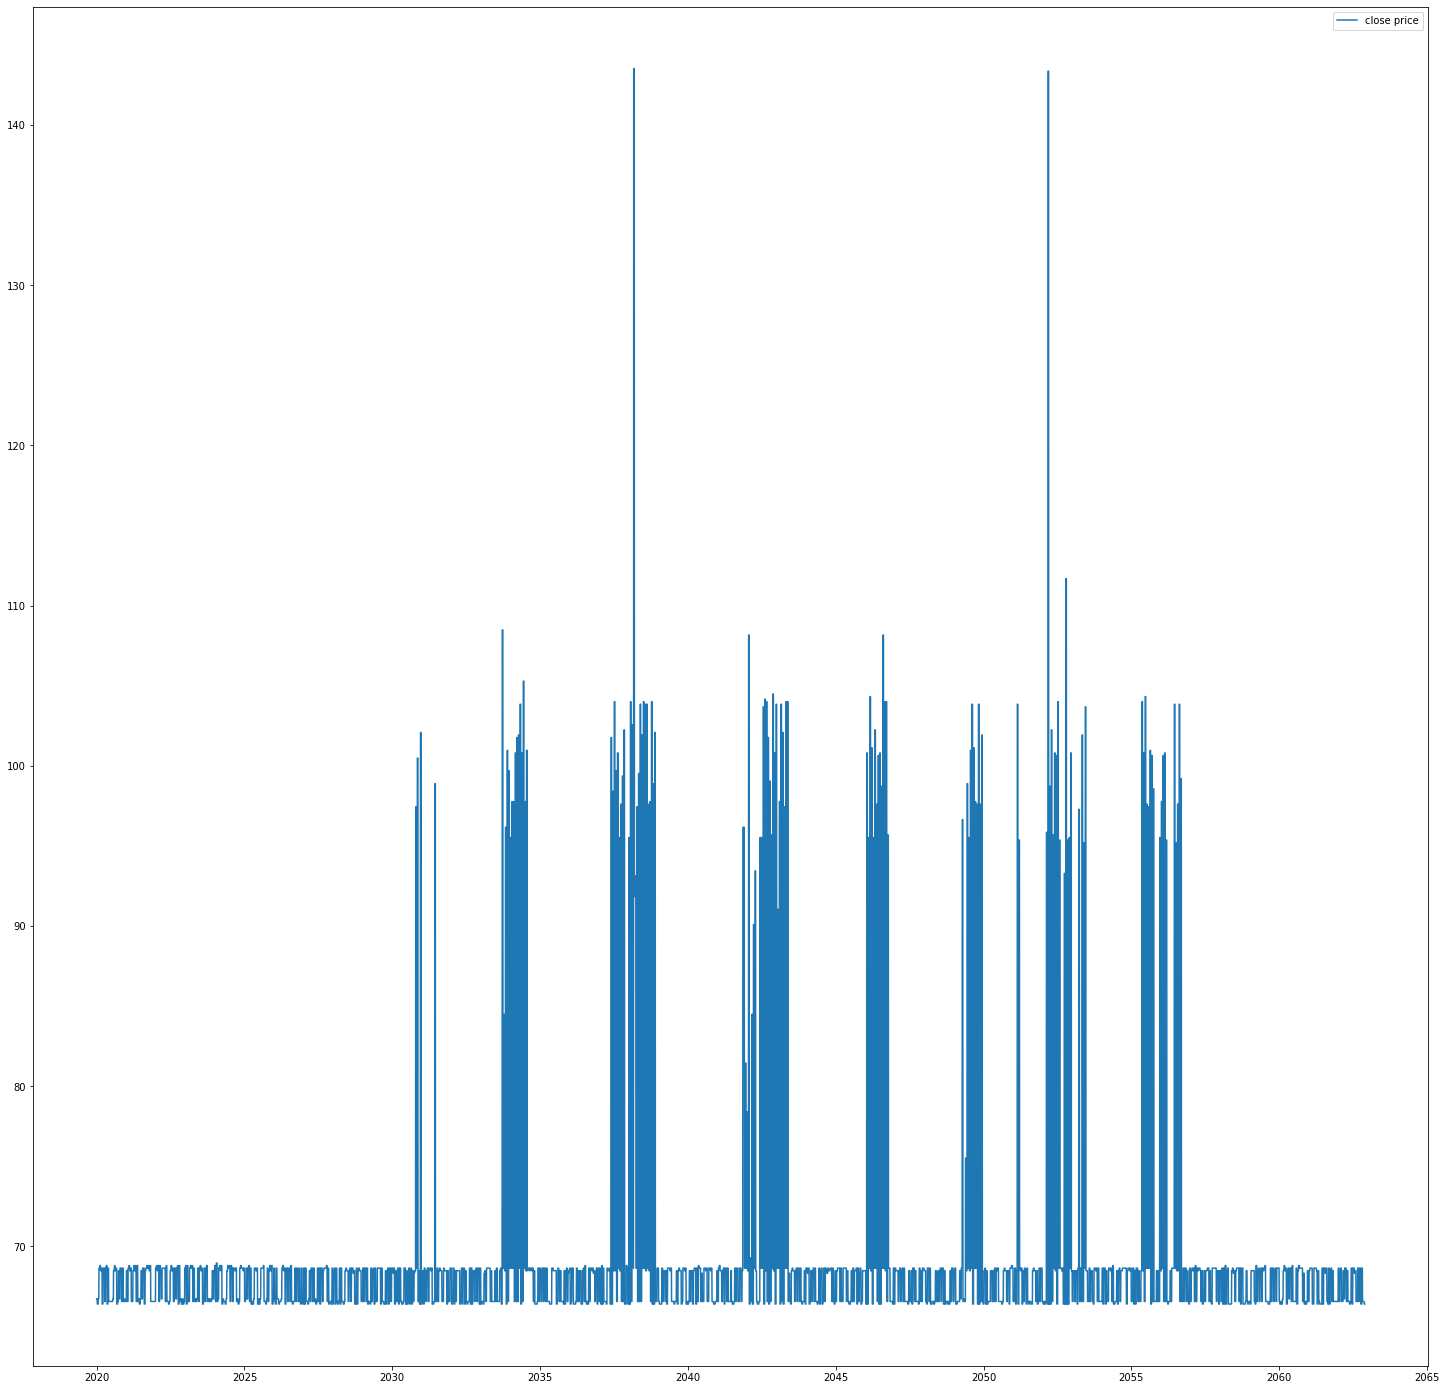

In [5]:
#df2=df1.astype(np.float64)
plt.figure(figsize=(25,25))
#sns.lineplot(data=X, dashes=False)
plt.plot(dataset, label='close price')
plt.legend();

In [6]:
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset.iloc[0:train_size], dataset.iloc[train_size:len(df)]
print(train.shape, test.shape)

(12536, 1) (3134, 1)


In [7]:
train.head()

,close
date,
2020-01-01,66.720001
2020-01-02,66.720001
2020-01-03,66.720001
2020-01-04,66.720001
2020-01-05,66.720001


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

c:\app\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\app\python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [9]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [10]:
TIME_STEPS = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

X_test.shape

(3124, 10, 1)

In [11]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.LSTM( units=64,
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64,return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 64)            33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 1)             65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
____________________________________________________

In [12]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Train on 11273 samples, validate on 1253 samples
Epoch 1/10
11273/11273 [==============================] - 10s 857us/sample - loss: 0.1704 - val_loss: 0.2041
Epoch 2/10
11273/11273 [==============================] - 5s 437us/sample - loss: 0.1157 - val_loss: 0.1923
Epoch 3/10
11273/11273 [==============================] - 5s 469us/sample - loss: 0.1028 - val_loss: 0.1648
Epoch 4/10
11273/11273 [==============================] - 5s 467us/sample - loss: 0.1009 - val_loss: 0.1683
Epoch 5/10
11273/11273 [==============================] - 5s 449us/sample - loss: 0.0985 - val_loss: 0.1617
Epoch 6/10
11273/11273 [==============================] - 6s 520us/sample - loss: 0.0985 - val_loss: 0.1710
Epoch 7/10
11273/11273 [==============================] - 5s 427us/sample - loss: 0.0986 - val_loss: 0.1579
Epoch 8/10
11273/11273 [==============================] - 5s 441us/sample - loss: 0.0969 - val_loss: 0.1464
Epoch 9/10
11273/11273 [==============================] - 5s 486us/sample - loss: 0.09

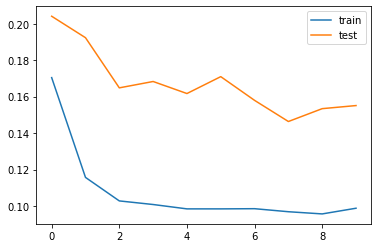

In [13]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [14]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

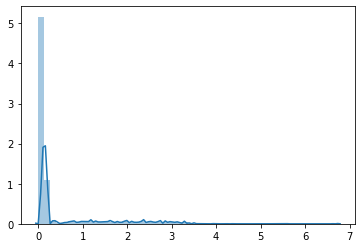

In [15]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [16]:

X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [17]:
print(test_mae_loss)

[[0.15855409]
 [0.13728695]
 [0.11569363]
 ...
 [0.00837451]
 [0.0080725 ]
 [0.00759915]]


In [18]:
#mean_loss = np.sum(test_mae_loss)/len(test_mae_loss)
THRESHOLD=2.0

In [25]:
test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

print(test_score_df)

                loss  threshold  anomaly     close
date                                              
2054-05-08  0.158554        2.0    False -0.392613
2054-05-09  0.137287        2.0    False -0.392613
2054-05-10  0.115694        2.0    False -0.392613
2054-05-11  0.093970        2.0    False -0.392613
2054-05-12  0.072233        2.0    False -0.392613
...              ...        ...      ...       ...
2062-11-21  0.009084        2.0    False -0.410382
2062-11-22  0.008716        2.0    False -0.410382
2062-11-23  0.008375        2.0    False -0.410382
2062-11-24  0.008073        2.0    False -0.410382
2062-11-25  0.007599        2.0    False -0.410382

[3124 rows x 4 columns]


In [26]:
test_score_df['close']

date
2054-05-08   -0.392613
2054-05-09   -0.392613
2054-05-10   -0.392613
2054-05-11   -0.392613
2054-05-12   -0.392613
                ...   
2062-11-21   -0.410382
2062-11-22   -0.410382
2062-11-23   -0.410382
2062-11-24   -0.410382
2062-11-25   -0.410382
Name: close, Length: 3124, dtype: float64

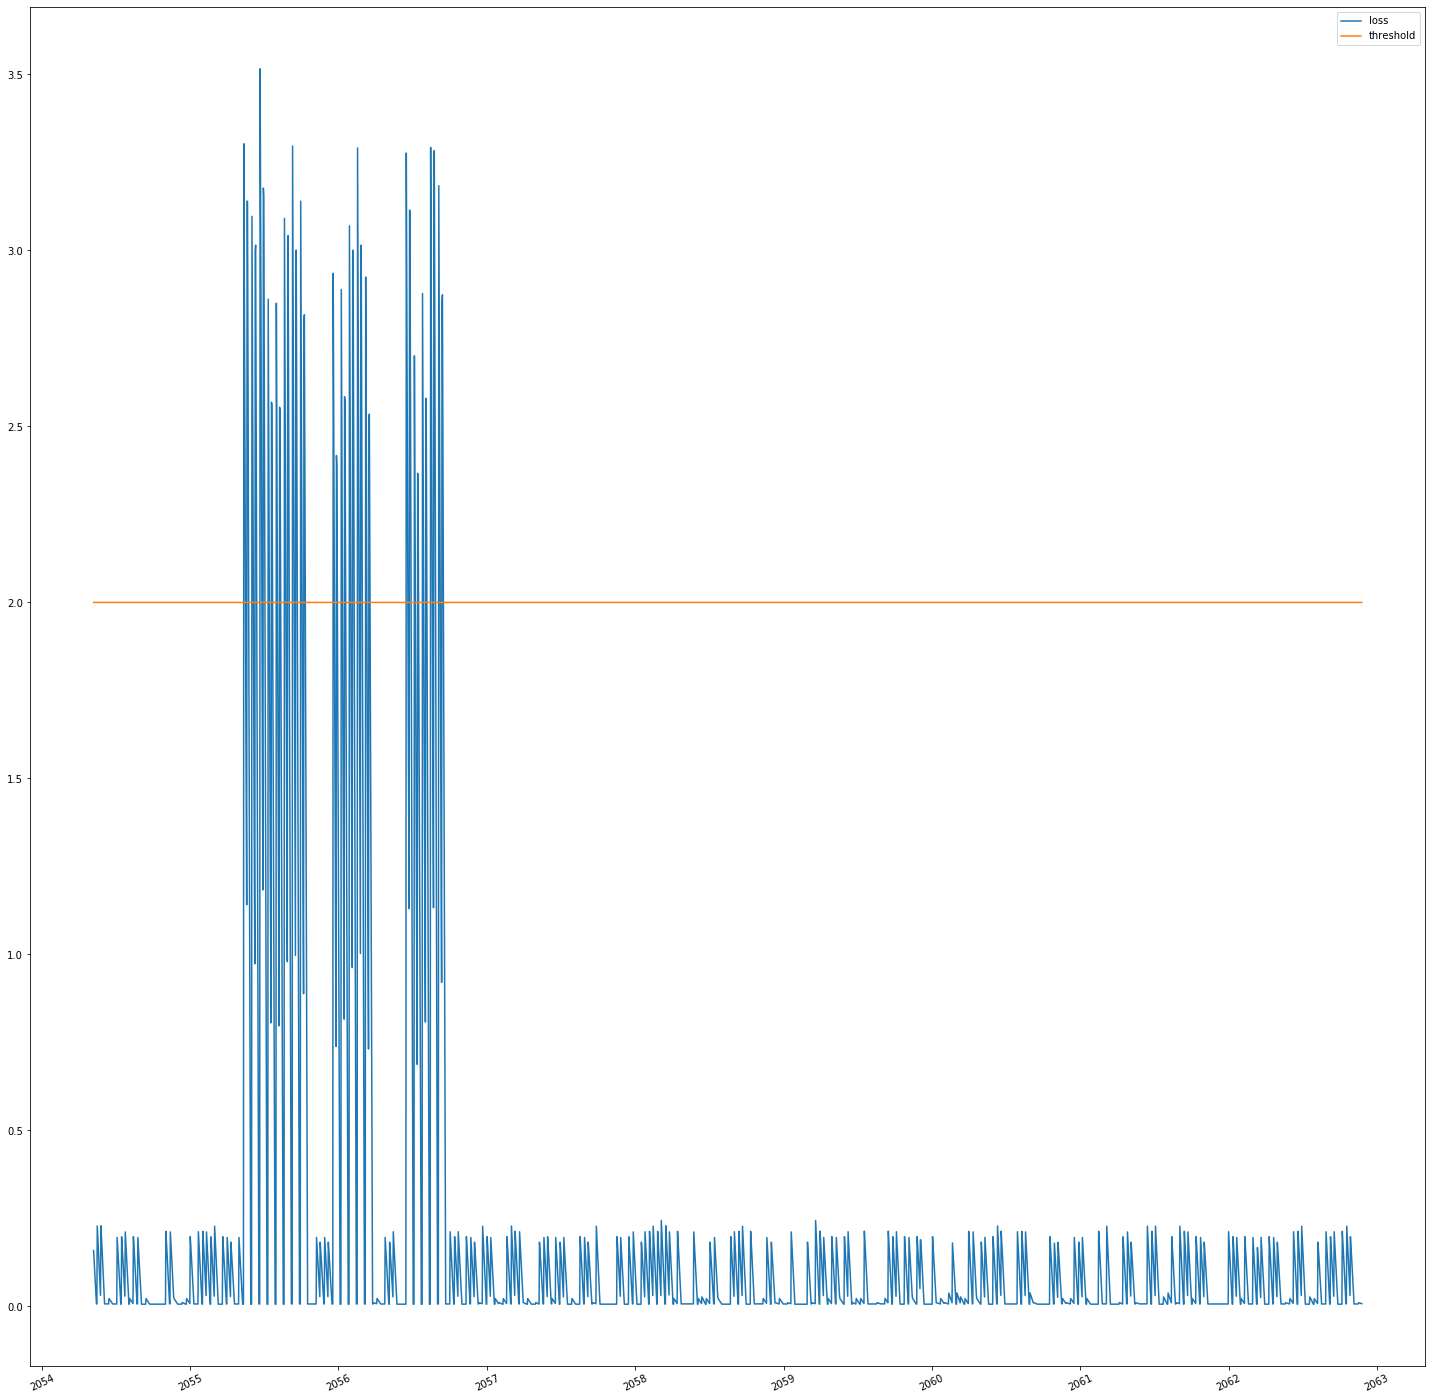

In [27]:
plt.figure(figsize=(25,25))
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [28]:

anomalies = test_score_df[test_score_df.anomaly == True]
print(anomalies)

                loss  threshold  anomaly     close
date                                              
2055-05-13  3.303079        2.0     True  3.765406
2055-05-14  3.005611        2.0     True  3.765406
2055-05-15  2.705837        2.0     True  3.765406
2055-05-16  2.352767        2.0     True  3.765406
2055-05-21  3.139411        2.0     True -0.179381
...              ...        ...      ...       ...
2056-09-07  2.174136        2.0     True  3.232326
2056-09-12  2.853420        2.0     True -0.392613
2056-09-13  2.873859        2.0     True -0.392613
2056-09-14  2.526102        2.0     True -0.392613
2056-09-15  2.171308        2.0     True -0.392613

[132 rows x 4 columns]


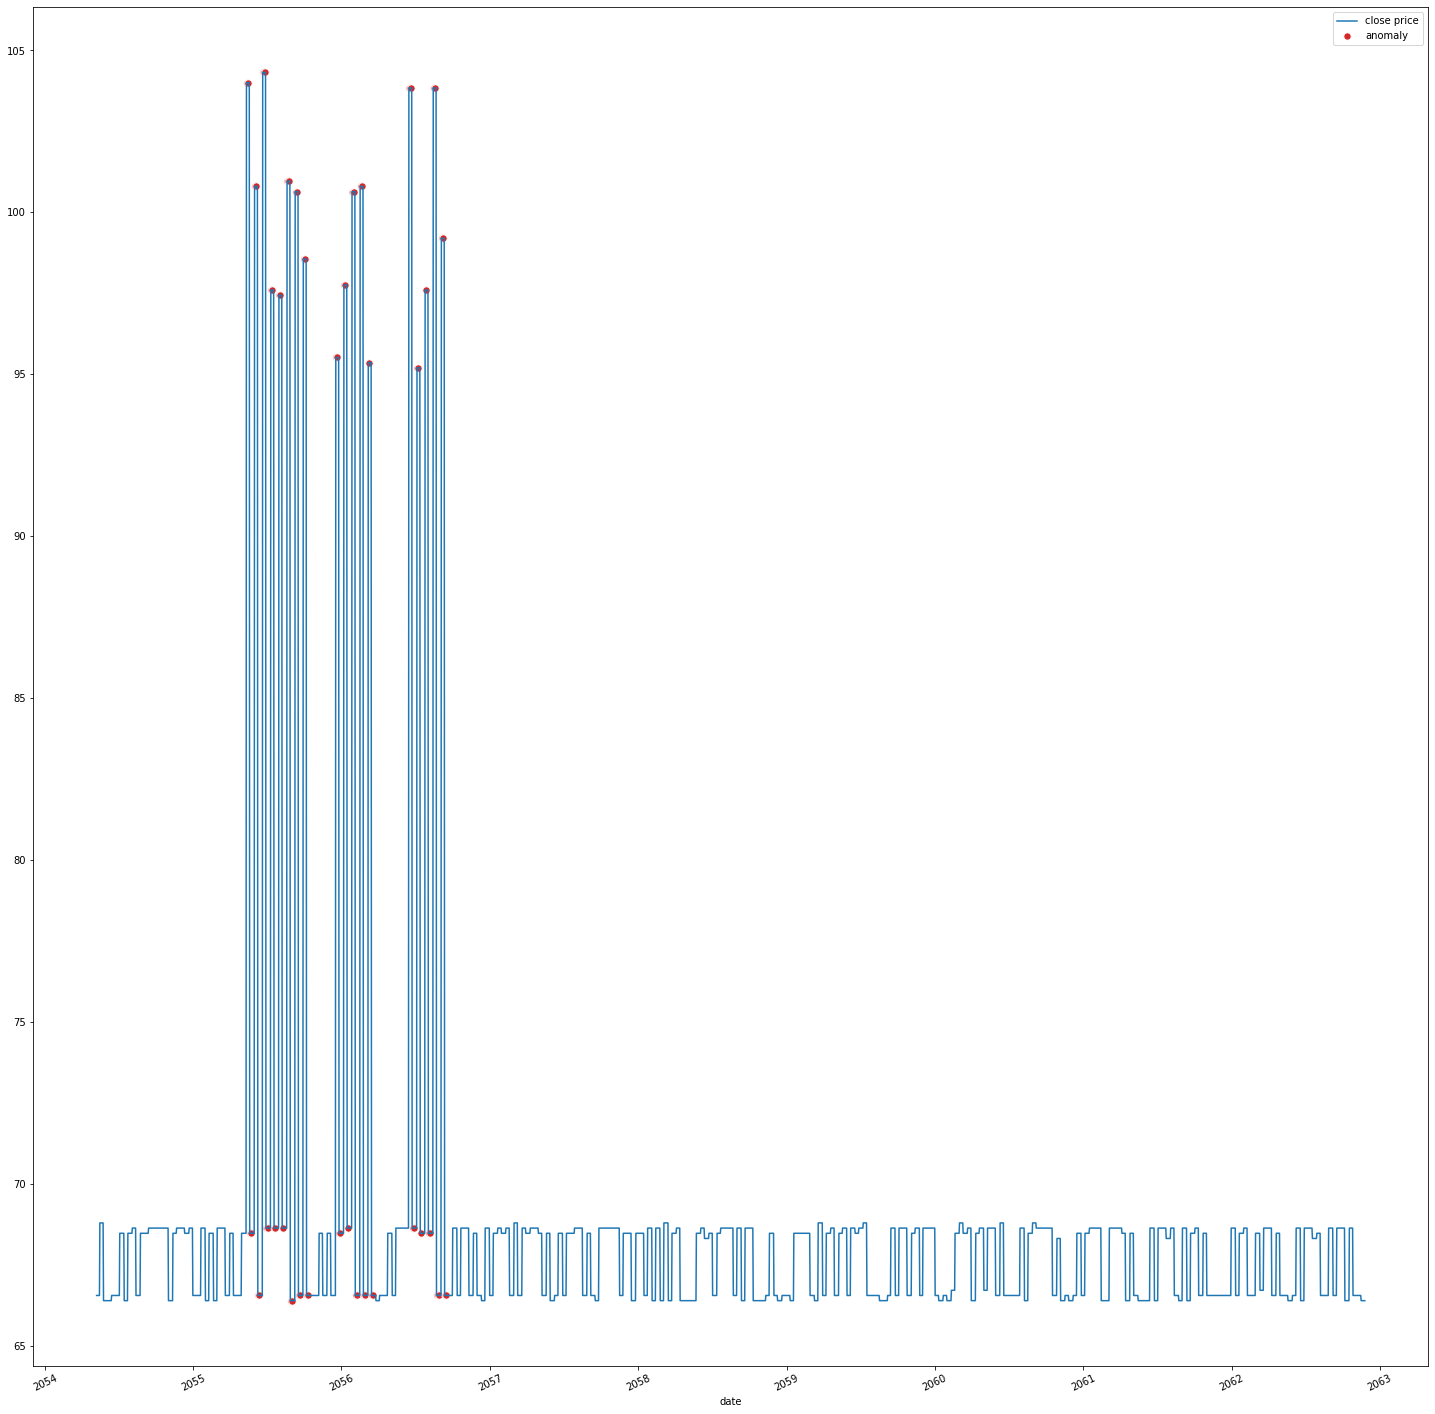

In [33]:
plt.figure(figsize=(25,25))
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].close), 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies['close']),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();

In [36]:
test

,close
date,
2054-04-28,-0.161612
2054-04-29,-0.161612
2054-04-30,-0.161612
2054-05-01,-0.161612
2054-05-02,-0.161612
...,...
2062-11-21,-0.410382
2062-11-22,-0.410382
2062-11-23,-0.410382
